# Over-sampling using LMNN

In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns
sns.set()

import numpy as np
import itertools

from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

# Save a nice dark grey as a variable
almost_black = '#262626'

%run '/home/glemaitre/anaconda/lib/python2.7/site-packages/modshogun.py'
import modshogun

Generate some data with dimension reduction to observed something.

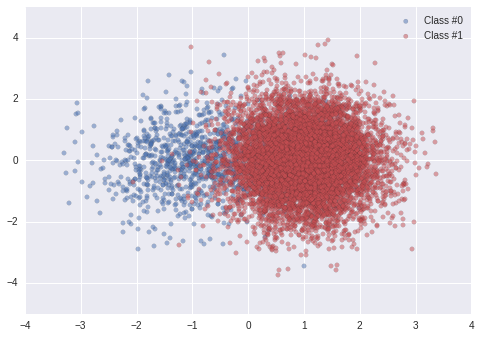

In [2]:
# Generate some data
x, y = make_classification(n_features=2, n_redundant=0, n_informative=1, class_sep=1.,
                           n_clusters_per_class=1, n_samples=10000, weights=[0.1, 0.9],
                           random_state=9)

# Instanciate a PCA object for the sake of easy visualisation
# pca = PCA(n_components = 2)

# Fit and transform x to visualise inside a 2D feature space
# x_vis = pca.fit_transform(x)

# Plot the original data
# Plot the two classes
palette = sns.color_palette()
plt.scatter(x[y==0, 0], x[y==0, 1], label="Class #0", alpha=0.5, 
            edgecolor=almost_black, facecolor=palette[0], linewidth=0.15)
plt.scatter(x[y==1, 0], x[y==1, 1], label="Class #1", alpha=0.5, 
            edgecolor=almost_black, facecolor=palette[2], linewidth=0.15)

plt.legend()
plt.show()

Compute the LMNN for each sample of the minority class

Counter({0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({1: 921, 0: 11})
Counter({1: 25, 0: 11})
Counter({0: 10})
Counter({1: 12, 0: 11})
Counter({0: 10, 1: 1})
Counter({0: 11, 1: 11})
Counter({0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({1: 411, 0: 10})
Counter({0: 11})
Counter({0: 10})
Counter({0: 11})
Counter({1: 14, 0: 11})
Counter({1: 997, 0: 11})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 1})
Counter({0: 11})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 8})
[[ 0.11174268 -0.01118491]
 [-0.01118491  0.18690633]]


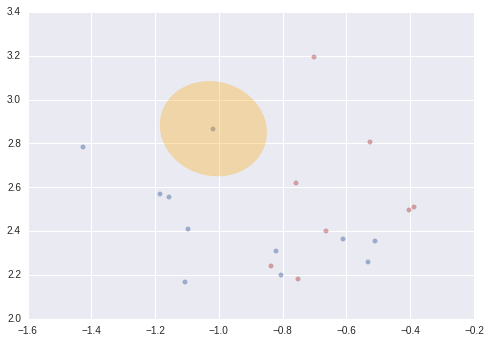

Counter({1: 1008, 0: 11})
Counter({0: 11})
Counter({0: 10, 1: 6})
[[ 0.01391217  0.0038445 ]
 [ 0.0038445   0.01149642]]


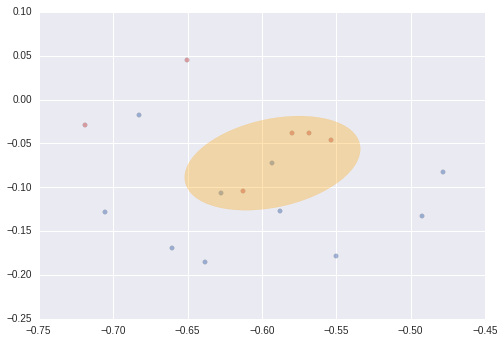

Counter({0: 11, 1: 2})
Counter({0: 10})
Counter({0: 11})
Counter({0: 11})
Counter({0: 10, 1: 1})
Counter({0: 11})
Counter({0: 10})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 6})
[[ 0.05802411 -0.00368111]
 [-0.00368111  0.07248673]]


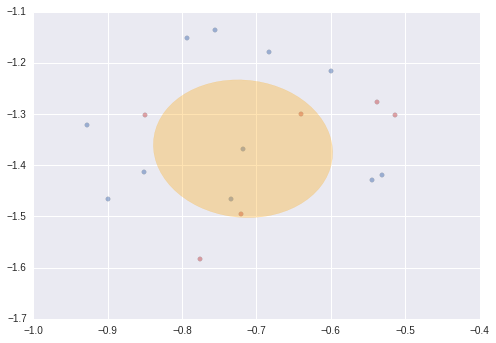

Counter({1: 62, 0: 11})
Counter({0: 11})
Counter({0: 10, 1: 8})
[[ 0.12217853 -0.00626054]
 [-0.00626054  0.1324698 ]]


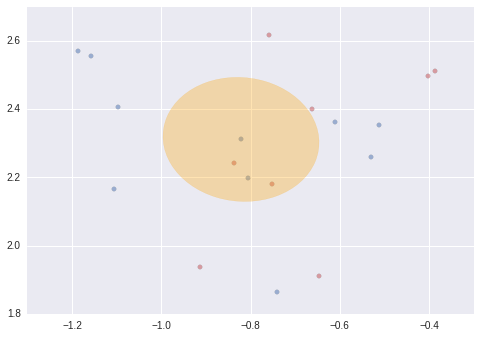

Counter({0: 11, 1: 1})
Counter({0: 10})
Counter({1: 40, 0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({1: 70, 0: 10})
Counter({0: 10, 1: 7})
[[ 0.02857709 -0.00045053]
 [-0.00045053  0.02282207]]


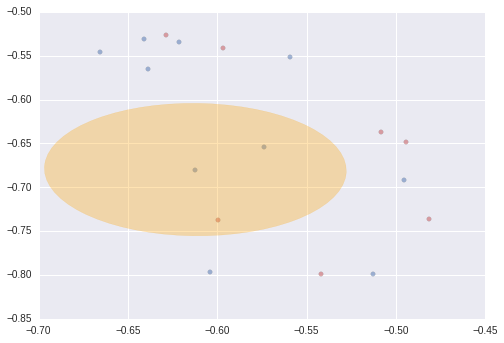

Counter({0: 11})
Counter({1: 166, 0: 11})
Counter({1: 151, 0: 11})
Counter({0: 11, 1: 4})
Counter({0: 11, 1: 2})
Counter({1: 395, 0: 11})
Counter({0: 11})
Counter({0: 10})
Counter({0: 10})
Counter({0: 11, 1: 3})
Counter({0: 11})
Counter({1: 18, 0: 10})
Counter({0: 11, 1: 4})
Counter({1: 31, 0: 10})
Counter({1: 1913, 0: 11})
Counter({0: 11, 1: 5})
Counter({1: 376, 0: 11})
Counter({1: 101, 0: 10})
Counter({0: 11})
Counter({1: 402, 0: 11})
Counter({1: 502, 0: 11})
Counter({0: 11, 1: 1})
Counter({0: 11})
Counter({0: 11, 1: 3})
Counter({0: 10, 1: 4})
Counter({1: 234, 0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({1: 81, 0: 10})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 2})
Counter({1: 16, 0: 11})
Counter({0: 11})
Counter({1: 685, 0: 11})
Counter({0: 11, 1: 1})
Counter({0: 11})
Counter({1: 110, 0: 11})
Counter({0: 10})
Counter({1: 121, 0: 11})
Counter({0: 11, 1: 1})
Counter({1: 21, 0: 11})
Counter({0: 11})
Counter({0: 11, 1: 10})
[[  9.86632994e-03   9.41627663e-05]
 [  

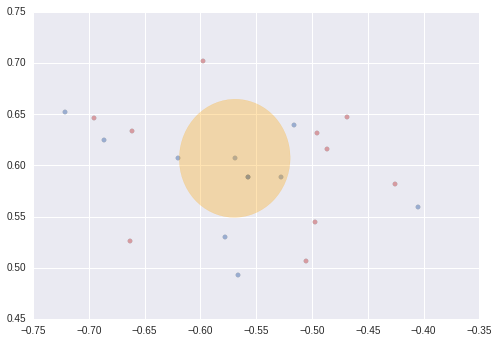

Counter({0: 10})
Counter({0: 10, 1: 3})
Counter({0: 10, 1: 1})
Counter({0: 11, 1: 1})
Counter({1: 130, 0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({0: 11, 1: 4})
Counter({1: 321, 0: 11})
Counter({0: 11})
Counter({0: 10})
Counter({1: 513, 0: 11})
Counter({0: 11, 1: 6})
[[ 0.01054235  0.00351528]
 [ 0.00351528  0.02076007]]


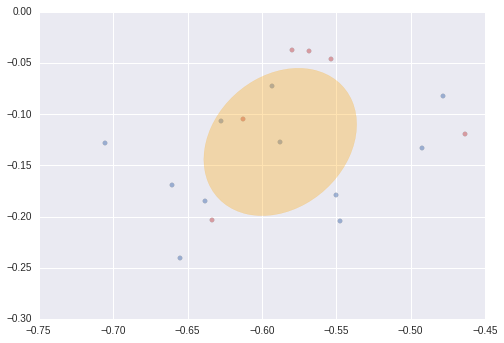

Counter({0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({1: 22, 0: 11})
Counter({0: 11})
Counter({1: 78, 0: 11})
Counter({0: 11, 1: 3})
Counter({0: 10})
Counter({0: 10})
Counter({1: 105, 0: 11})
Counter({0: 11, 1: 11})
Counter({1: 155, 0: 11})
Counter({0: 11, 1: 1})
Counter({0: 10, 1: 2})
Counter({0: 11})
Counter({0: 11, 1: 4})
Counter({1: 304, 0: 11})
Counter({1: 655, 0: 11})
Counter({0: 11, 1: 5})
Counter({0: 10, 1: 3})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 6})
[[ 0.01450045  0.00574582]
 [ 0.00574582  0.01673053]]


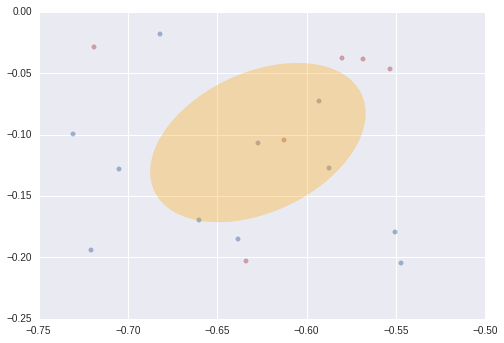

Counter({1: 63, 0: 11})
Counter({0: 11})
Counter({1: 93, 0: 11})
Counter({0: 11})
Counter({0: 11, 1: 1})
Counter({1: 1548, 0: 11})
Counter({1: 132, 0: 10})
Counter({1: 15, 0: 10})
Counter({0: 11})
Counter({1: 735, 0: 11})
Counter({0: 11, 1: 2})
Counter({0: 10})
Counter({1: 35, 0: 10})
Counter({0: 11, 1: 4})
Counter({0: 11, 1: 10})
[[ 0.02865822 -0.0022022 ]
 [-0.0022022   0.02488196]]


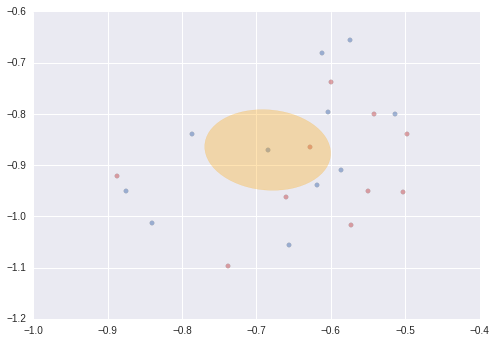

Counter({0: 11})
Counter({1: 12, 0: 10})
Counter({1: 19, 0: 11})
Counter({1: 753, 0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({1: 63, 0: 10})
Counter({0: 11, 1: 3})
Counter({1: 158, 0: 10})
Counter({0: 10})
Counter({0: 11})
Counter({1: 14, 0: 10})
Counter({1: 236, 0: 10})
Counter({1: 139, 0: 11})
Counter({1: 14, 0: 11})
Counter({0: 11, 1: 3})
Counter({0: 11, 1: 7})
[[ 0.00951593  0.0036201 ]
 [ 0.0036201   0.01330538]]


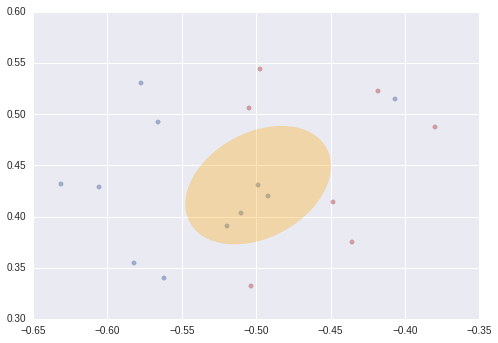

Counter({1: 737, 0: 11})
Counter({0: 11, 1: 10})
[[ 0.00785819 -0.00073023]
 [-0.00073023  0.00739522]]


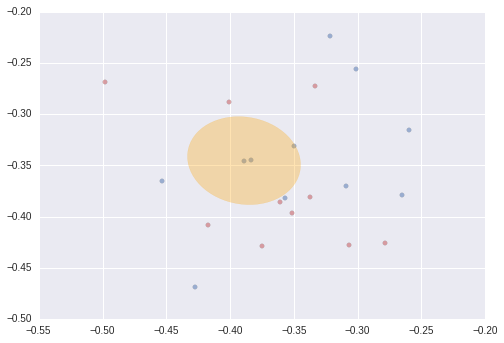

Counter({0: 11})
Counter({0: 10})
Counter({0: 11})
Counter({1: 28, 0: 11})
Counter({0: 11, 1: 4})
Counter({1: 166, 0: 11})
Counter({0: 11, 1: 3})
Counter({0: 10})
Counter({0: 10, 1: 4})
Counter({1: 161, 0: 11})
Counter({0: 11})
Counter({1: 24, 0: 10})
Counter({0: 11, 1: 3})
Counter({0: 10})
Counter({0: 11})
Counter({1: 767, 0: 11})
Counter({0: 11})
Counter({0: 10})
Counter({0: 11})
Counter({1: 375, 0: 11})
Counter({0: 11})
Counter({0: 11, 1: 3})
Counter({0: 11, 1: 1})
Counter({1: 55, 0: 11})
Counter({1: 55, 0: 11})
Counter({1: 11, 0: 10})
Counter({1: 735, 0: 11})
Counter({0: 10})
Counter({0: 10, 1: 4})
Counter({1: 131, 0: 11})
Counter({0: 11, 1: 3})
Counter({0: 11, 1: 1})
Counter({1: 55, 0: 11})
Counter({0: 10})
Counter({1: 57, 0: 10})
Counter({0: 10})
Counter({0: 11, 1: 1})
Counter({1: 57, 0: 11})
Counter({0: 10, 1: 1})
Counter({0: 10, 1: 1})
Counter({0: 11})
Counter({0: 11})
Counter({0: 11, 1: 1})
Counter({1: 97, 0: 11})
Counter({0: 11})
Counter({1: 25, 0: 10})
Counter({0: 11})
Count

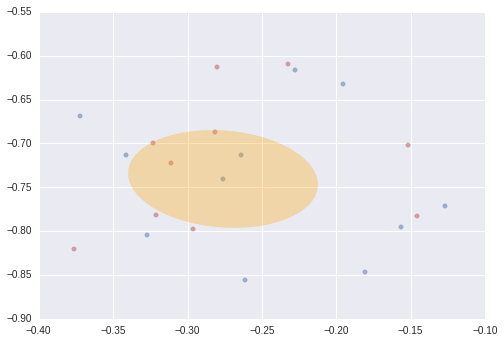

Counter({1: 12, 0: 11})
Counter({1: 80, 0: 11})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 3})
Counter({0: 11, 1: 7})
[[ 0.01015436  0.0030318 ]
 [ 0.0030318   0.01046556]]


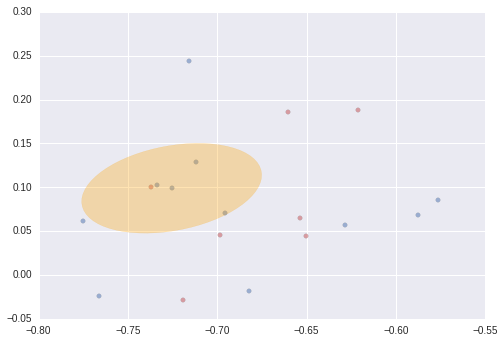

Counter({0: 11})
Counter({0: 10, 1: 1})
Counter({1: 150, 0: 11})
Counter({0: 11})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 3})
Counter({0: 10, 1: 10})
Counter({1: 83, 0: 11})
Counter({0: 11})
Counter({1: 674, 0: 11})
Counter({0: 11})
Counter({1: 12, 0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({1: 337, 0: 10})
Counter({0: 10, 1: 3})
Counter({0: 11})
Counter({0: 11, 1: 11})
Counter({0: 10})
Counter({0: 10})
Counter({0: 11, 1: 4})
Counter({0: 11})
Counter({0: 10})
Counter({1: 199, 0: 10})
Counter({0: 11})
Counter({0: 10})
Counter({0: 11, 1: 1})
Counter({0: 11})
Counter({0: 11, 1: 3})
Counter({0: 11})
Counter({1: 905, 0: 11})
Counter({0: 10})
Counter({0: 10, 1: 3})
Counter({1: 60, 0: 10})
Counter({1: 82, 0: 11})
Counter({0: 11})
Counter({1: 14, 0: 11})
Counter({0: 11})
Counter({1: 100, 0: 11})
Counter({0: 11})
Counter({0: 10})
Counter({0: 11, 1: 2})
Counter({0: 11})
Counter({0: 11})
Counter({0: 10})
Counter({0: 11, 1: 1})
Counter({0: 11})
Counter({0: 11, 1: 5})
Counter({0: 10})
Coun

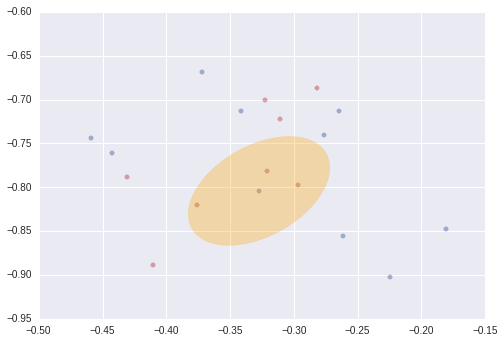

Counter({0: 11, 1: 2})
Counter({1: 236, 0: 11})
Counter({0: 11, 1: 11})
Counter({1: 31, 0: 10})
Counter({0: 10})
Counter({0: 10})
Counter({0: 10})
Counter({0: 11})
Counter({0: 11, 1: 3})
Counter({0: 11, 1: 4})
Counter({1: 593, 0: 11})
Counter({1: 1360, 0: 11})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 4})
Counter({0: 11})
Counter({0: 11, 1: 2})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 2})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 10})
[[ 0.00641954  0.00145524]
 [ 0.00145524  0.0106595 ]]


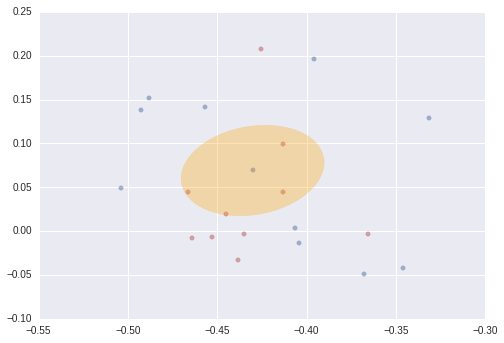

Counter({0: 11, 1: 2})
Counter({0: 11, 1: 9})
[[ 0.01571489  0.00302579]
 [ 0.00302579  0.01938085]]


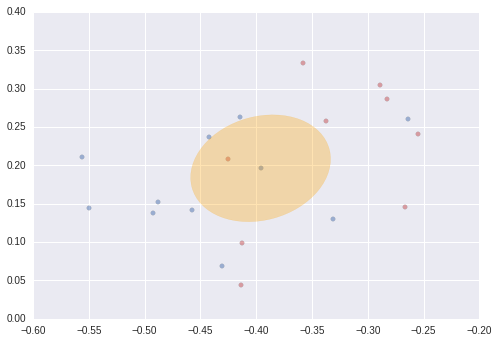

Counter({1: 1586, 0: 11})
Counter({0: 11})
Counter({1: 20, 0: 11})
Counter({0: 10, 1: 1})
Counter({0: 11, 1: 1})
Counter({1: 160, 0: 11})
Counter({0: 11, 1: 11})
Counter({0: 10})
Counter({0: 11})
Counter({0: 11})
Counter({1: 838, 0: 10})
Counter({1: 19, 0: 10})
Counter({0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({0: 11, 1: 3})
Counter({0: 10, 1: 10})
Counter({1: 12, 0: 10})
Counter({0: 11, 1: 11})
Counter({0: 11, 1: 2})
Counter({1: 12, 0: 11})
Counter({1: 113, 0: 11})
Counter({0: 11, 1: 1})
Counter({1: 20, 0: 10})
Counter({0: 11, 1: 2})
Counter({0: 10})
Counter({0: 11})
Counter({1: 783, 0: 11})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 5})
Counter({1: 13, 0: 11})
Counter({1: 15, 0: 11})
Counter({0: 11, 1: 1})
Counter({1: 184, 0: 11})
Counter({1: 187, 0: 11})
Counter({1: 67, 0: 10})
Counter({0: 11})
Counter({0: 11})
Counter({0: 10, 1: 3})
Counter({0: 10, 1: 1})
Counter({0: 11, 1: 11})
Counter({0: 11})
Counter({0: 11})
Counter({1: 32, 0: 11})
Counter({1: 19, 0: 11})
Counter({1: 13

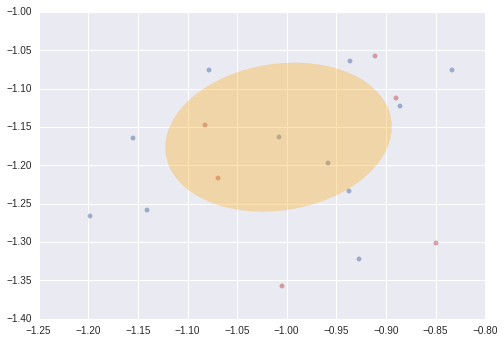

Counter({0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({1: 151, 0: 11})
Counter({1: 17, 0: 10})
Counter({0: 11, 1: 1})
Counter({1: 317, 0: 11})
Counter({0: 11})
Counter({1: 126, 0: 11})
Counter({1: 54, 0: 11})
Counter({1: 44, 0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({0: 10})
Counter({0: 11})
Counter({0: 10, 1: 1})
Counter({0: 11, 1: 1})
Counter({0: 10, 1: 9})
[[ 0.01351186  0.00137534]
 [ 0.00137534  0.01331634]]


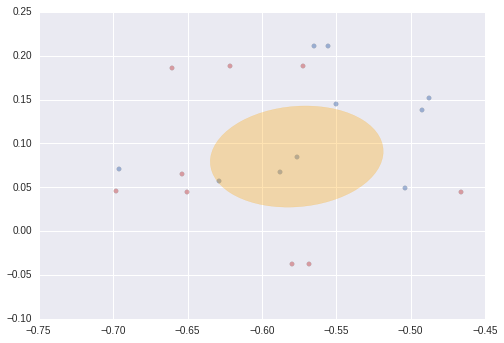

Counter({0: 11, 1: 4})
Counter({1: 35, 0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({0: 10, 1: 1})
Counter({1: 96, 0: 11})
Counter({0: 11, 1: 3})
Counter({0: 11})
Counter({1: 91, 0: 11})
Counter({0: 11})
Counter({0: 11, 1: 1})
Counter({0: 10})
Counter({0: 10, 1: 3})
Counter({0: 11, 1: 10})
[[ 0.00497114 -0.00159464]
 [-0.00159464  0.00609509]]


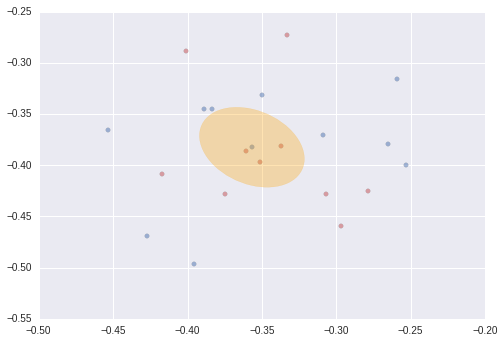

Counter({0: 11})
Counter({0: 11})
Counter({1: 271, 0: 11})
Counter({0: 10, 1: 2})
Counter({1: 28, 0: 10})
Counter({0: 11})
Counter({0: 11, 1: 2})
Counter({0: 10})
Counter({0: 11})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 1})
Counter({0: 10})
Counter({1: 82, 0: 11})
Counter({0: 11})
Counter({1: 13, 0: 11})
Counter({0: 11})
Counter({0: 11, 1: 1})
Counter({0: 11})
Counter({0: 11})
Counter({0: 10, 1: 5})
Counter({0: 10})
Counter({0: 11, 1: 3})
Counter({0: 11})
Counter({0: 11, 1: 3})
Counter({0: 10})
Counter({0: 10, 1: 2})
Counter({0: 11})
Counter({1: 139, 0: 11})
Counter({1: 34, 0: 10})
Counter({0: 10})
Counter({1: 49, 0: 11})
Counter({0: 10})
Counter({0: 10, 1: 4})
Counter({0: 11})
Counter({0: 11, 1: 1})
Counter({0: 10, 1: 5})
Counter({0: 11})
Counter({0: 11, 1: 11})
Counter({1: 38, 0: 11})
Counter({0: 11, 1: 1})
Counter({0: 11})
Counter({0: 11, 1: 4})
Counter({1: 12, 0: 11})
Counter({0: 11, 1: 7})
[[ 0.01160433  0.00022122]
 [ 0.00022122  0.01925352]]


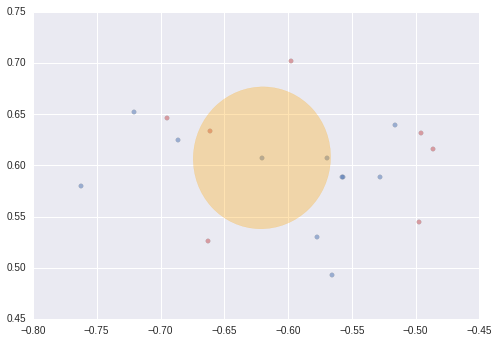

Counter({0: 10, 1: 8})
[[ 0.01370906 -0.00052111]
 [-0.00052111  0.00485483]]


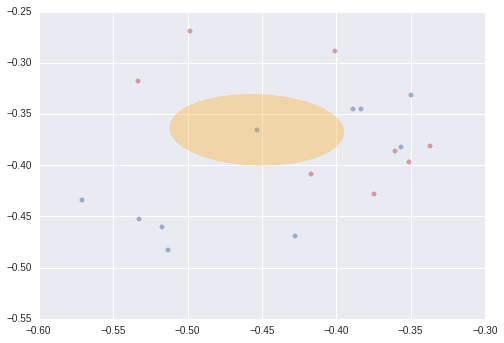

Counter({1: 14, 0: 11})
Counter({0: 10, 1: 1})
Counter({0: 10, 1: 10})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 1})
Counter({1: 616, 0: 11})
Counter({1: 55, 0: 10})
Counter({0: 11, 1: 11})
Counter({0: 11})
Counter({1: 16, 0: 11})
Counter({1: 955, 0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({0: 11, 1: 4})
Counter({0: 11, 1: 8})
[[ 0.01444463  0.00127948]
 [ 0.00127948  0.01542647]]


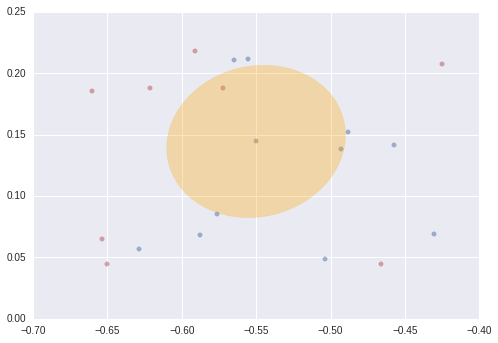

Counter({0: 11, 1: 1})
Counter({0: 10})
Counter({0: 10})
Counter({0: 11})
Counter({1: 48, 0: 11})
Counter({1: 518, 0: 11})
Counter({0: 11, 1: 9})
[[ 0.00663325  0.00021168]
 [ 0.00021168  0.00575284]]


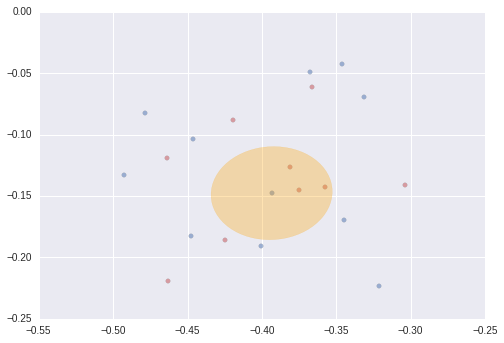

Counter({1: 110, 0: 11})
Counter({1: 1719, 0: 11})
Counter({0: 11})
Counter({0: 10, 1: 4})
Counter({0: 11})
Counter({1: 28, 0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({0: 10, 1: 1})
Counter({0: 10, 1: 2})
Counter({0: 11})
Counter({0: 11, 1: 5})
Counter({0: 11})
Counter({0: 10})
Counter({1: 21, 0: 11})
Counter({1: 45, 0: 11})
Counter({1: 56, 0: 10})
Counter({1: 19, 0: 11})
Counter({0: 11, 1: 4})
Counter({0: 10, 1: 2})
Counter({0: 11})
Counter({0: 11})
Counter({1: 17, 0: 10})
Counter({0: 11, 1: 9})
[[ 0.02927304 -0.00075677]
 [-0.00075677  0.030424  ]]


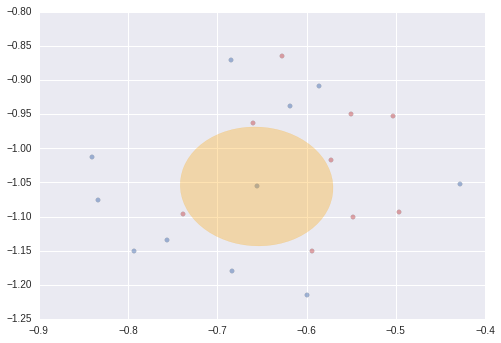

Counter({0: 11})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 1})
Counter({1: 13, 0: 10})
Counter({1: 726, 0: 10})
Counter({0: 11})
Counter({0: 11, 1: 2})
Counter({0: 11})
Counter({1: 25, 0: 11})
Counter({1: 168, 0: 11})
Counter({0: 10, 1: 1})
Counter({0: 11, 1: 9})
[[ 0.03461976 -0.00369961]
 [-0.00369961  0.03020735]]


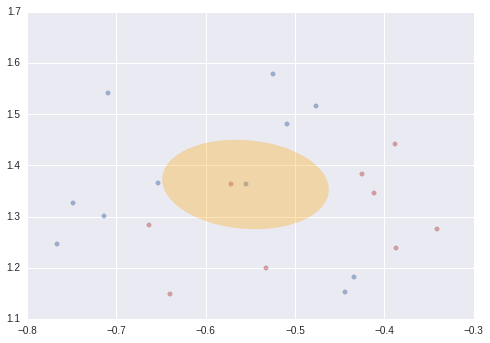

Counter({1: 370, 0: 11})
Counter({1: 59, 0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({0: 11, 1: 7})
[[ 0.11453517  0.0205305 ]
 [ 0.0205305   0.13393889]]


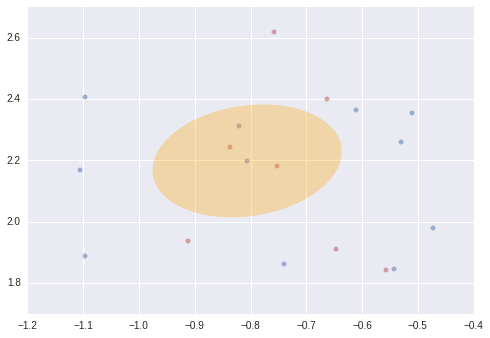

Counter({0: 10, 1: 1})
Counter({0: 11, 1: 4})
Counter({0: 11})
Counter({0: 11, 1: 5})
Counter({0: 11})
Counter({1: 26, 0: 10})
Counter({1: 59, 0: 10})
Counter({1: 15, 0: 11})
Counter({0: 11, 1: 2})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 2})
Counter({0: 11, 1: 4})
Counter({1: 1533, 0: 11})
Counter({0: 11})
Counter({0: 11, 1: 8})
[[ 0.07843716  0.00017349]
 [ 0.00017349  0.07783859]]


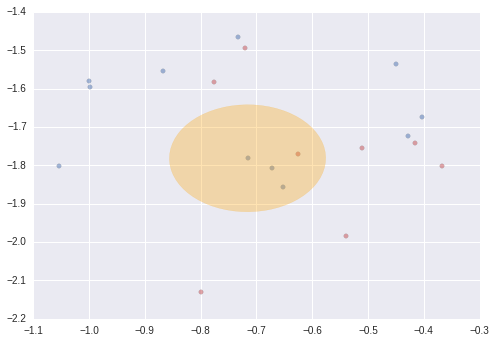

Counter({0: 10, 1: 8})
[[ 0.0486499   0.00366142]
 [ 0.00366142  0.04307989]]


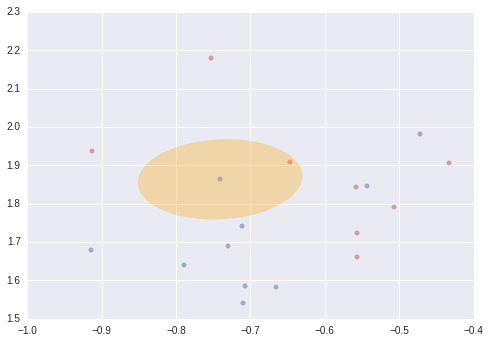

Counter({0: 10})
Counter({0: 11, 1: 4})
Counter({0: 10, 1: 1})
Counter({0: 11, 1: 3})
Counter({1: 16, 0: 11})
Counter({1: 91, 0: 11})
Counter({1: 182, 0: 10})
Counter({1: 642, 0: 11})
Counter({1: 90, 0: 10})
Counter({0: 11, 1: 8})
[[ 0.02183142  0.00336057]
 [ 0.00336057  0.02564733]]


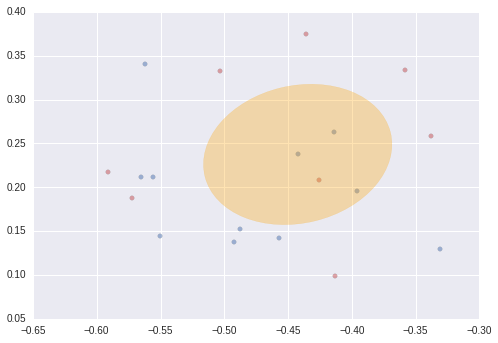

Counter({0: 10})
Counter({0: 10, 1: 1})
Counter({0: 10})
Counter({0: 11})
Counter({1: 14, 0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({0: 11, 1: 5})
Counter({0: 10, 1: 1})
Counter({0: 11})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 3})
Counter({0: 10, 1: 3})
Counter({0: 11})
Counter({0: 11})
Counter({0: 10})
Counter({0: 11})
Counter({0: 11})
Counter({0: 11, 1: 1})
Counter({0: 10})
Counter({0: 11, 1: 1})
Counter({0: 11})
Counter({0: 10, 1: 6})
[[ 0.2221713  -1.10784004]
 [-1.10784004  6.94806026]]


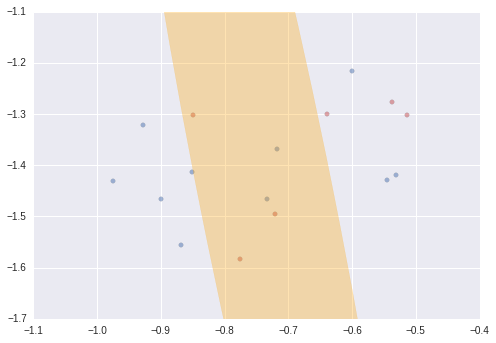

Counter({1: 1899, 0: 11})
Counter({1: 77, 0: 11})
Counter({0: 10, 1: 7})
[[ 0.00938086  0.00229641]
 [ 0.00229641  0.01179903]]


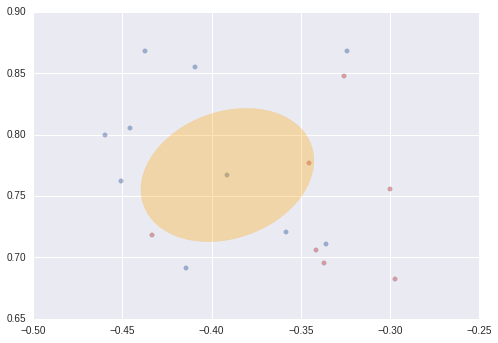

Counter({0: 11, 1: 2})
Counter({1: 373, 0: 11})
Counter({0: 11})
Counter({1: 1725, 0: 11})
Counter({0: 11, 1: 1})
Counter({1: 145, 0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({1: 720, 0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({0: 11, 1: 8})
[[ 0.01530928  0.0014646 ]
 [ 0.0014646   0.01830249]]


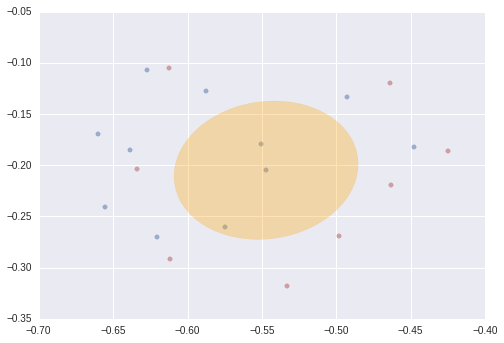

Counter({0: 11})
Counter({0: 11})
Counter({0: 11, 1: 5})
Counter({0: 10, 1: 1})
Counter({1: 36, 0: 11})
Counter({0: 11, 1: 3})
Counter({0: 11})
Counter({0: 11})
Counter({1: 1776, 0: 11})
Counter({0: 10})
Counter({1: 17, 0: 11})
Counter({1: 61, 0: 10})
Counter({0: 10, 1: 4})
Counter({1: 520, 0: 10})
Counter({0: 11})
Counter({0: 11})
Counter({1: 80, 0: 11})
Counter({1: 76, 0: 11})
Counter({1: 28, 0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({1: 41, 0: 11})
Counter({0: 11, 1: 1})
Counter({0: 11})
Counter({0: 10, 1: 6})
[[ 0.0201931  -0.00022348]
 [-0.00022348  0.01435133]]


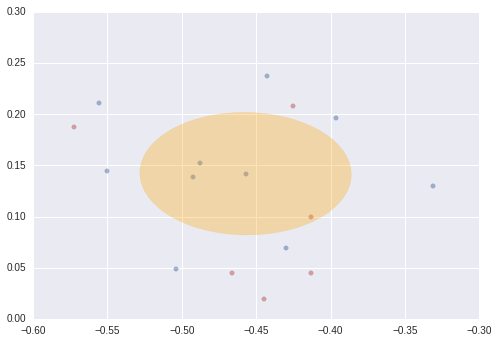

Counter({0: 11})
Counter({0: 10, 1: 6})
[[ 0.01266197 -0.00152279]
 [-0.00152279  0.0102122 ]]


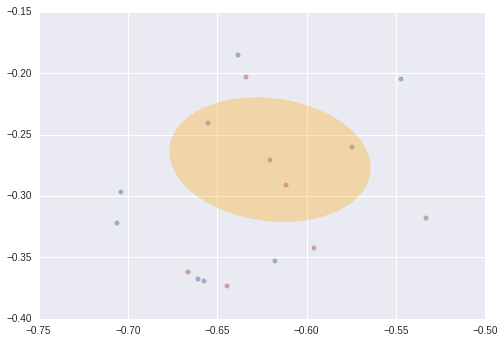

Counter({1: 52, 0: 11})
Counter({0: 11, 1: 2})
Counter({0: 10})
Counter({0: 11, 1: 8})
[[ 0.04012681  0.01080684]
 [ 0.01080684  0.03644524]]


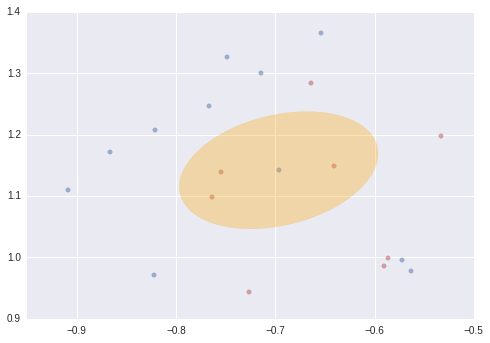

Counter({0: 11, 1: 2})
Counter({0: 10, 1: 1})
Counter({1: 95, 0: 11})
Counter({1: 18, 0: 11})
Counter({0: 11})
Counter({0: 10, 1: 1})
Counter({0: 10})
Counter({0: 11})
Counter({0: 11})
Counter({0: 10, 1: 4})
Counter({0: 11})
Counter({1: 53, 0: 11})
Counter({0: 11, 1: 9})
[[ 0.00580722 -0.00129279]
 [-0.00129279  0.0072051 ]]


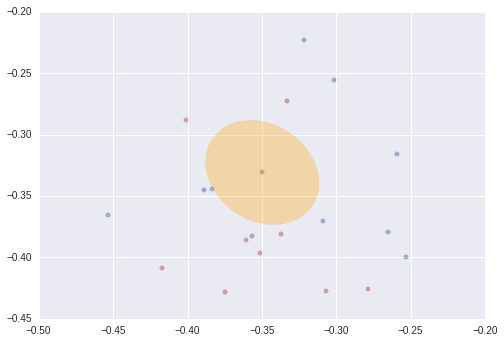

Counter({0: 11, 1: 3})
Counter({1: 82, 0: 11})
Counter({1: 441, 0: 11})
Counter({1: 940, 0: 11})
Counter({1: 38, 0: 11})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 4})
Counter({0: 11, 1: 3})
Counter({0: 10, 1: 5})
Counter({1: 37, 0: 11})
Counter({0: 11})
Counter({0: 10, 1: 4})
Counter({1: 21, 0: 11})
Counter({1: 39, 0: 11})
Counter({0: 10, 1: 4})
Counter({0: 11})
Counter({1: 151, 0: 11})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 6})
[[ 0.01177103  0.00372872]
 [ 0.00372872  0.01129881]]


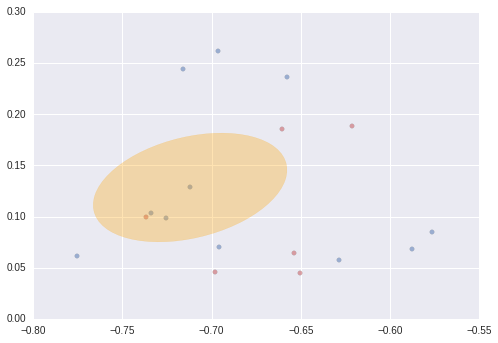

Counter({1: 218, 0: 11})
Counter({0: 11})
Counter({0: 10, 1: 1})
Counter({0: 11})
Counter({0: 11})
Counter({0: 10})
Counter({1: 81, 0: 11})
Counter({0: 10})
Counter({1: 14, 0: 11})
Counter({0: 11, 1: 4})
Counter({0: 11, 1: 4})
Counter({1: 45, 0: 10})
Counter({0: 11})
Counter({1: 135, 0: 10})
Counter({0: 11})
Counter({0: 11, 1: 2})
Counter({0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({1: 12, 0: 11})
Counter({0: 11, 1: 1})
Counter({1: 67, 0: 11})
Counter({0: 11})
Counter({0: 10})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 1})
Counter({0: 11})
Counter({0: 11, 1: 11})
Counter({1: 502, 0: 11})
Counter({0: 11})
Counter({0: 10})
Counter({0: 11, 1: 10})
[[ 0.01174844  0.00224073]
 [ 0.00224073  0.01308361]]


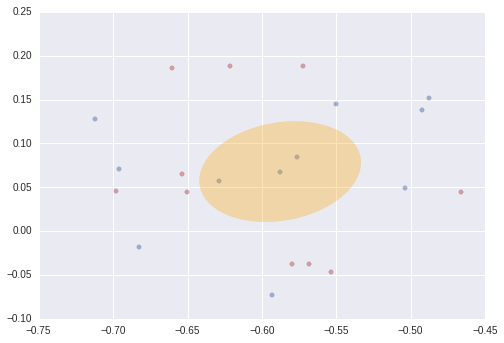

Counter({1: 12, 0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({0: 10})
Counter({1: 52, 0: 11})
Counter({0: 11, 1: 1})
Counter({1: 12, 0: 11})
Counter({1: 375, 0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({1: 74, 0: 11})
Counter({0: 10, 1: 7})
[[ 0.02409757  0.00213223]
 [ 0.00213223  0.02219439]]


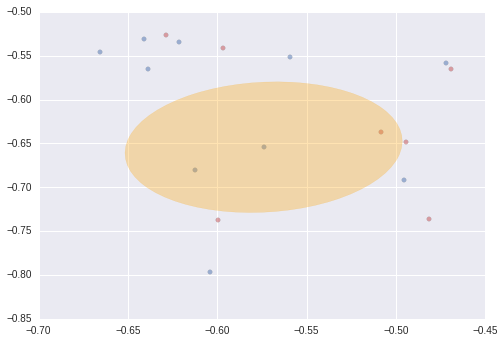

Counter({0: 11})
Counter({0: 11})
Counter({0: 11, 1: 2})
Counter({0: 11})
Counter({0: 11})
Counter({0: 11, 1: 1})
Counter({1: 16, 0: 11})
Counter({0: 11, 1: 5})
Counter({0: 11})
Counter({0: 10, 1: 1})
Counter({1: 89, 0: 11})
Counter({1: 2245, 0: 10})
Counter({1: 22, 0: 11})
Counter({1: 44, 0: 11})
Counter({0: 11})
Counter({1: 30, 0: 11})
Counter({1: 23, 0: 11})
Counter({1: 99, 0: 11})
Counter({1: 90, 0: 10})
Counter({0: 11})
Counter({1: 474, 0: 11})
Counter({0: 10})
Counter({1: 117, 0: 11})
Counter({1: 1278, 0: 10})
Counter({0: 11})
Counter({0: 11})
Counter({1: 171, 0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({1: 134, 0: 11})
Counter({0: 11, 1: 4})
Counter({0: 11})
Counter({0: 11})
Counter({0: 10, 1: 1})
Counter({0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({0: 10, 1: 2})
Counter({1: 538, 0: 11})
Counter({0: 10})
Counter({0: 11, 1: 4})
Counter({1: 555, 0: 11})
Counter({1: 72, 0: 11})
Counter({0: 11, 1: 4})
Counter({1: 42, 0: 11})
Counter({1: 21, 0: 11})
Counter({0: 11, 1: 1}

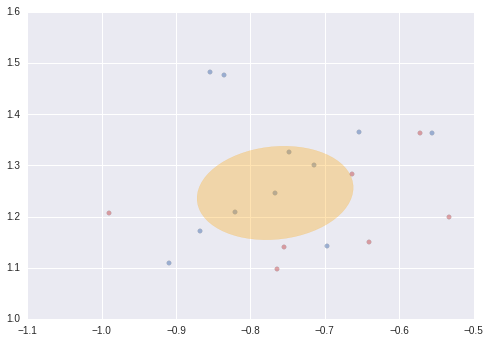

Counter({0: 11})
Counter({0: 11, 1: 1})
Counter({0: 11})
Counter({0: 11})
Counter({1: 164, 0: 11})
Counter({0: 11, 1: 3})
Counter({0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({0: 11, 1: 4})
Counter({0: 10, 1: 1})
Counter({1: 34, 0: 10})
Counter({1: 532, 0: 11})
Counter({0: 11})
Counter({1: 415, 0: 11})
Counter({1: 14, 0: 11})
Counter({0: 11})
Counter({0: 11, 1: 3})
Counter({1: 172, 0: 10})
Counter({1: 53, 0: 11})
Counter({0: 11, 1: 4})
Counter({0: 11, 1: 1})
Counter({0: 10, 1: 4})
Counter({0: 11, 1: 4})
Counter({0: 10})
Counter({0: 11})
Counter({1: 39, 0: 11})
Counter({0: 10})
Counter({1: 274, 0: 11})
Counter({0: 10})
Counter({1: 21, 0: 11})
Counter({1: 786, 0: 11})
Counter({0: 10})
Counter({0: 11})
Counter({0: 11})
Counter({0: 10, 1: 7})
[[ 0.01053311  0.00205434]
 [ 0.00205434  0.00834269]]


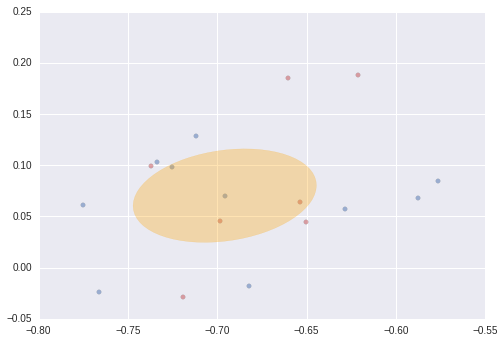

Counter({1: 436, 0: 10})
Counter({0: 11})
Counter({1: 148, 0: 11})
Counter({0: 11, 1: 1})
Counter({1: 23, 0: 11})
Counter({0: 11, 1: 3})
Counter({1: 64, 0: 10})
Counter({0: 11})
Counter({0: 11})
Counter({0: 10, 1: 6})
[[ 0.01674104  0.00375116]
 [ 0.00375116  0.01106077]]


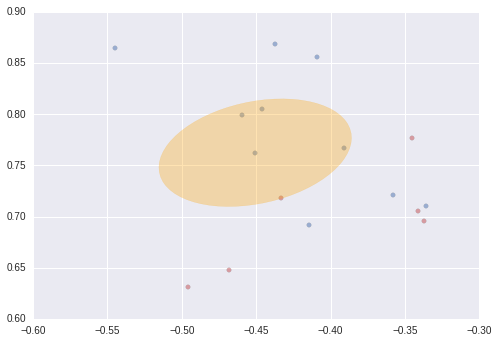

Counter({0: 11, 1: 9})
[[ 0.00645652 -0.00107745]
 [-0.00107745  0.00773155]]


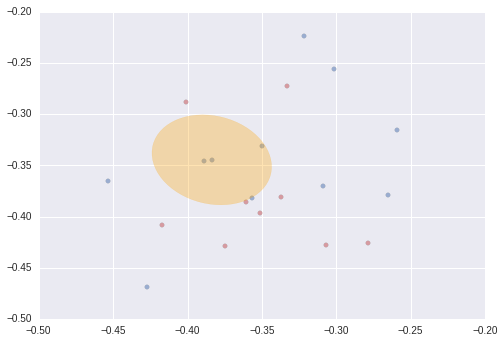

Counter({0: 11})
Counter({1: 13, 0: 11})
Counter({0: 11, 1: 7})
[[ 0.01319352  0.00246505]
 [ 0.00246505  0.01384738]]


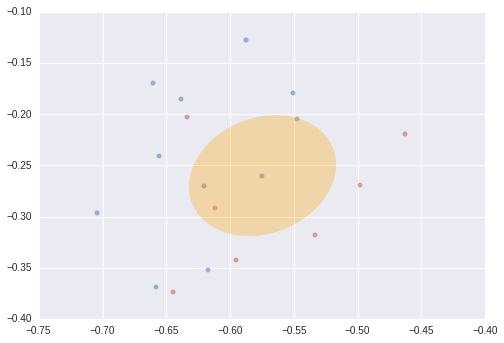

Counter({0: 10})
Counter({0: 11})
Counter({1: 12, 0: 10})
Counter({0: 11})
Counter({0: 11, 1: 1})
Counter({1: 14, 0: 11})
Counter({1: 168, 0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({1: 35, 0: 11})
Counter({0: 11})
Counter({1: 1283, 0: 11})
Counter({0: 11})
Counter({1: 62, 0: 11})
Counter({1: 39, 0: 11})
Counter({0: 11, 1: 2})
Counter({1: 178, 0: 11})
Counter({1: 71, 0: 10})
Counter({0: 10, 1: 6})
[[ 0.05568407 -0.00120311]
 [-0.00120311  0.04004655]]


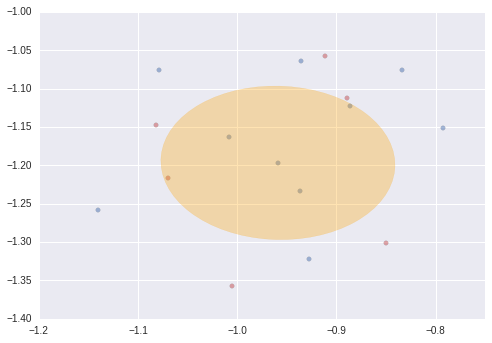

Counter({0: 10})
Counter({0: 10})
Counter({0: 11})
Counter({1: 71, 0: 11})
Counter({0: 11})
Counter({1: 37, 0: 11})
Counter({0: 11})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 1})
Counter({0: 10})
Counter({0: 11, 1: 3})
Counter({0: 11, 1: 1})
Counter({0: 10})
Counter({0: 11, 1: 5})
Counter({0: 10})
Counter({0: 11, 1: 3})
Counter({0: 11})
Counter({0: 11})
Counter({1: 98, 0: 11})
Counter({1: 797, 0: 11})
Counter({0: 11})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 1})
Counter({0: 11})
Counter({1: 47, 0: 11})
Counter({1: 14, 0: 11})
Counter({0: 11})
Counter({0: 11, 1: 8})
[[ 0.46880728  0.02038437]
 [ 0.02038437  0.32500744]]


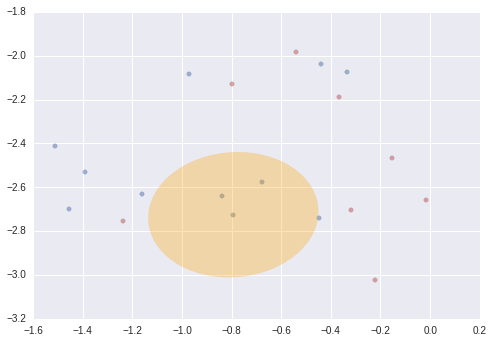

Counter({1: 49, 0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({0: 11, 1: 2})
Counter({0: 10})
Counter({0: 11})
Counter({0: 11})
Counter({1: 57, 0: 11})
Counter({0: 11, 1: 2})
Counter({0: 11, 1: 3})
Counter({0: 11, 1: 1})
Counter({1: 1654, 0: 11})
Counter({0: 11})
Counter({0: 11, 1: 7})
[[ 0.01256463  0.00348925]
 [ 0.00348925  0.01398554]]


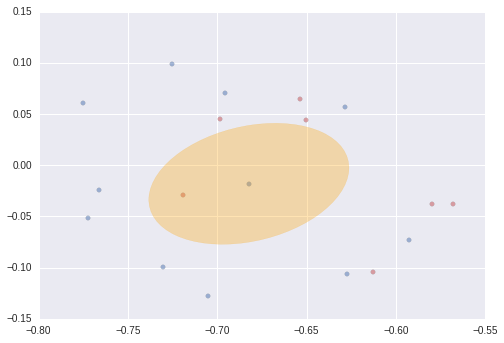

Counter({0: 11, 1: 2})
Counter({0: 11})
Counter({0: 11, 1: 1})
Counter({0: 10})
Counter({0: 10})
Counter({0: 11, 1: 4})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 6})
[[ 0.03230388  0.00827762]
 [ 0.00827762  0.03400599]]


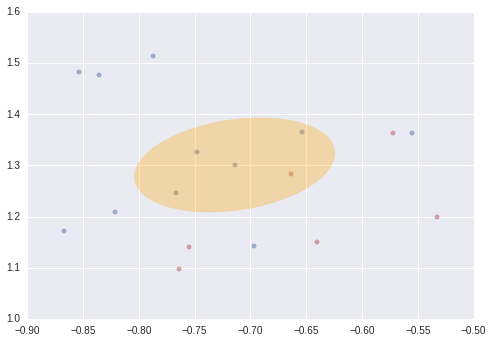

Counter({1: 16, 0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({1: 1474, 0: 10})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 1})
Counter({1: 23, 0: 11})
Counter({0: 10, 1: 1})
Counter({0: 11})
Counter({0: 11})
Counter({0: 11, 1: 1})
Counter({1: 22, 0: 11})
Counter({0: 11})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 5})
Counter({0: 10})
Counter({1: 16, 0: 11})
Counter({0: 10, 1: 6})
[[ 0.07067371 -0.00081036]
 [-0.00081036  0.03334486]]


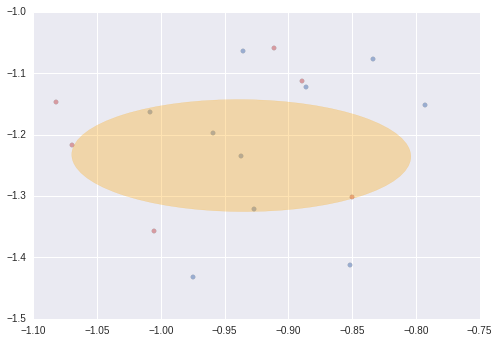

Counter({0: 11})
Counter({0: 10, 1: 1})
Counter({1: 17, 0: 11})
Counter({1: 13, 0: 10})
Counter({0: 11, 1: 4})
Counter({1: 51, 0: 10})
Counter({0: 11})
Counter({0: 11})
Counter({0: 11})
Counter({1: 80, 0: 10})
Counter({0: 11})
Counter({0: 11, 1: 11})
Counter({0: 11})
Counter({0: 10, 1: 3})
Counter({0: 10})
Counter({0: 11, 1: 9})
[[ 0.01116234  0.00420265]
 [ 0.00420265  0.00982989]]


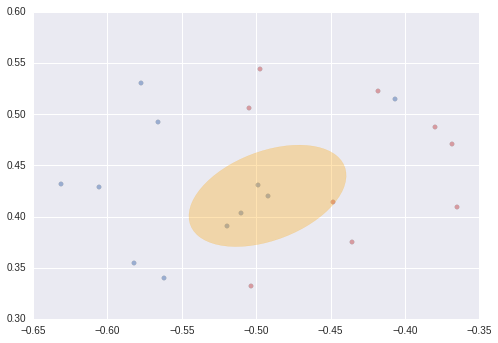

Counter({0: 10, 1: 6})
[[ 0.02558829 -0.00323168]
 [-0.00323168  0.00982367]]


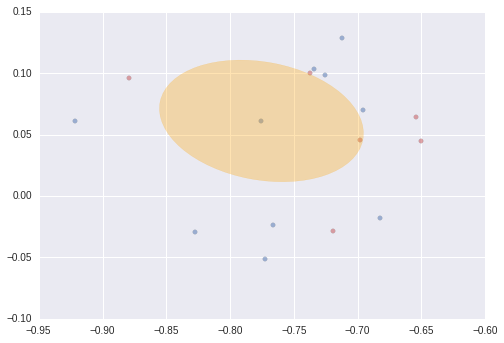

Counter({0: 11, 1: 1})
Counter({0: 11, 1: 1})
Counter({0: 11})
Counter({0: 10})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 1})
Counter({0: 11})
Counter({1: 32, 0: 11})
Counter({1: 34, 0: 11})
Counter({1: 643, 0: 11})
Counter({0: 11, 1: 4})
Counter({0: 10, 1: 5})
Counter({0: 11})
Counter({0: 11})
Counter({0: 10, 1: 1})
Counter({0: 10, 1: 5})
Counter({1: 1536, 0: 11})
Counter({1: 97, 0: 10})
Counter({0: 10, 1: 1})
Counter({1: 54, 0: 11})
Counter({0: 11, 1: 5})
Counter({0: 11})
Counter({0: 11})
Counter({1: 56, 0: 11})
Counter({0: 11, 1: 3})
Counter({0: 11})
Counter({1: 15, 0: 11})
Counter({0: 10, 1: 9})
[[ 0.01349368  0.00058308]
 [ 0.00058308  0.01375535]]


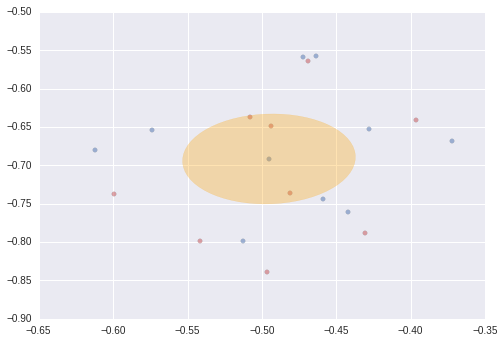

Counter({0: 11, 1: 8})
[[ 0.01280416  0.00174018]
 [ 0.00174018  0.01147676]]


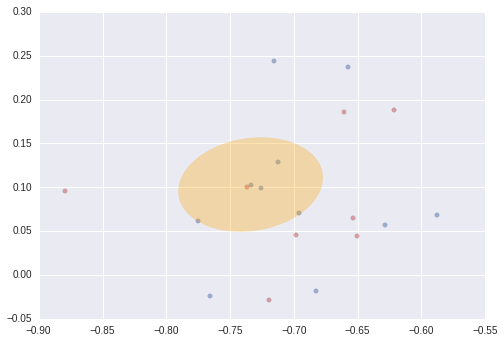

Counter({0: 10})
Counter({0: 11, 1: 2})
Counter({0: 11})
Counter({0: 11})
Counter({0: 11, 1: 3})
Counter({0: 10, 1: 4})
Counter({0: 11})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 2})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 3})
Counter({0: 11, 1: 1})
Counter({1: 216, 0: 11})
Counter({1: 12, 0: 10})
Counter({1: 613, 0: 10})
Counter({1: 61, 0: 11})
Counter({0: 11, 1: 8})
[[ 0.03698516 -0.00308469]
 [-0.00308469  0.04489487]]


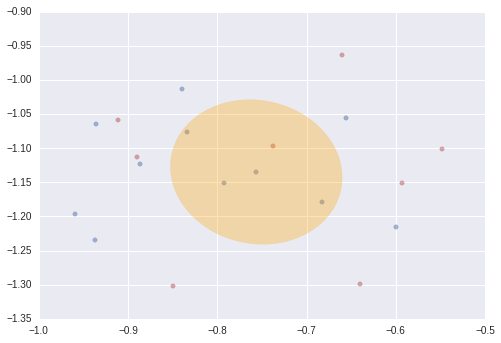

Counter({1: 732, 0: 11})
Counter({0: 11, 1: 1})
Counter({0: 11})
Counter({0: 11, 1: 11})
Counter({1: 260, 0: 11})
Counter({0: 11})
Counter({0: 10, 1: 1})
Counter({1: 20, 0: 10})
Counter({0: 11})
Counter({0: 11})
Counter({0: 10, 1: 2})
Counter({0: 11, 1: 7})
[[ 0.47719447 -0.01232469]
 [-0.01232469  0.4305194 ]]


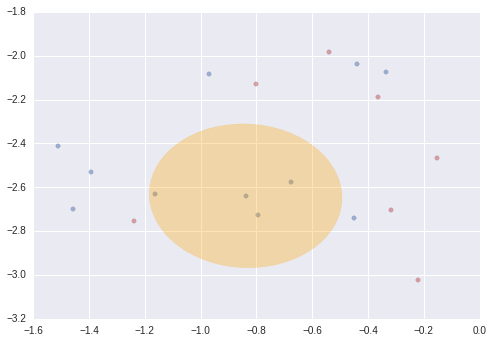

Counter({0: 10, 1: 4})
Counter({0: 11, 1: 1})
Counter({1: 14, 0: 10})
Counter({0: 11})
Counter({1: 41, 0: 11})
Counter({1: 25, 0: 10})
Counter({0: 10})
Counter({0: 10, 1: 1})
Counter({0: 11, 1: 1})
Counter({0: 11, 1: 11})


In [5]:
from collections import Counter

# Compute the classes representation
stat_class = Counter(y)
# Find the minority class key
label_min_class = min(stat_class, key=stat_class.get)
label_maj_class = max(stat_class, key=stat_class.get)
# Save the sample index of this class
idx_min_class = np.ravel(np.nonzero(y == label_min_class))
idx_maj_class = np.ravel(np.nonzero(y == label_maj_class))

from sklearn.neighbors import NearestNeighbors

neighbours_required = 11

# Create an object NN only for the minority class
min_class_NN = NearestNeighbors(n_neighbors=neighbours_required, metric='l2')#, n_jobs=-1)
min_class_NN.fit(x[idx_min_class, :], y[idx_min_class])

# Create an object NN only for the majority class
max_class_NN = NearestNeighbors(n_neighbors=neighbours_required, metric='l2')#, n_jobs=-1)
max_class_NN.fit(x[idx_maj_class, :], y[idx_maj_class])

# Create an object NN for the whole dataset
data_NN = NearestNeighbors(n_neighbors=1, metric='l2')#,n_jobs=-1)
data_NN.fit(x, y)

# Compute all the distance of the k-NN on the minority class on the original data for the point of the minority class
dist_min, ind_min = min_class_NN.kneighbors(x[idx_min_class, :])
# Compute all the distance of the k-NN on the majority class on the original data for the point of the minority class
dist_max, ind_max = max_class_NN.kneighbors(x[idx_min_class, :])
# Find the largest distance for the both above distances
dist_min = np.max(dist_min, axis=1)
dist_max = np.max(dist_max, axis=1)

# Select the max_dist between dist_min and dist_max to ensure a minimum of neighbours
#max_dist = dist_max.copy()
max_dist = dist_min.copy()
#max_dist[np.nonzero(dist_min < dist_max)] = dist_max[np.nonzero(dist_min < dist_max)]
#max_dist[np.nonzero(dist_min > dist_max)] = dist_min[np.nonzero(dist_min > dist_max)]

# Now find the samples to consider with the distance extracted using only the minority class
# We need to loop since that the distance is changing
s_considers = []
for s, d, tmpi in zip(x[idx_min_class], max_dist, idx_min_class):
    dist, ind = data_NN.radius_neighbors(X=np.atleast_2d(s), radius=d)
    a = ind[0]
    # Move to the first position the index of interest
    idxint = np.nonzero(a==tmpi)
    a[idxint] = a[0]
    a[0] = tmpi
    s_considers.append(a)
    
from metric_learn import LMNN, ITML, SDML, LSML

cov_mat = []
idx_cons = []
for s in s_considers:
    # Extract the interesting data
    x_s = x[np.ravel(s), :]
    y_s = y[np.ravel(s)]
        
    # Check if there is any imposter
    stat = Counter(y_s)
    print stat
    
    num_constraints = 200
    
    if (len(stat) > 1):
        if (stat[label_min_class] > stat[label_maj_class]):
            #print (stat[label_maj_class] / stat[label_min_class])
            if ((float(stat[label_min_class]) / float(stat[label_maj_class])) > 1 and 
                (float(stat[label_min_class]) / float(stat[label_maj_class])) < 2):
                
                # Fit the LMNN for these data
                s_lmnn = LMNN(k=3, convergence_tol=1e-9, min_iter=5000, max_iter=5000)
                s_lmnn.fit(x_s, y_s)
                #s_lmnn = ITML(max_iters=5000, convergence_threshold=1e-9)
                #s_lmnn.fit(x_s, ITML.prepare_constraints(y_s, x_s.shape[0], num_constraints))
                

                figure, axis = plt.subplots(1,1)
                plt.scatter(x_s[y_s==0, 0], x_s[y_s==0, 1], label="Class #0", alpha=0.5, 
                edgecolor=almost_black, facecolor=palette[0], linewidth=0.15)
                plt.scatter(x_s[y_s==1, 0], x_s[y_s==1, 1], label="Class #1", alpha=0.5, 
                edgecolor=almost_black, facecolor=palette[2], linewidth=0.15)
                cm = np.matrix(s_lmnn.metric())
                print np.matrix(cm).I
                elli = make_covariance_ellipse(np.matrix(cm).I, x_s[0], 1)
                axis.add_artist(elli)
                plt.show()

                # Store the covariance matrix
                cov_mat.append(np.matrix(s_lmnn.metric()))
                idx_cons.append(True)
            else:
                cov_mat.append(np.ma.cov(x_s.T))
                idx_cons.append(False)
        else:
            cov_mat.append(np.ma.cov(x_s.T))
            idx_cons.append(False)
    else:
        cov_mat.append(np.ma.cov(x_s.T))
        idx_cons.append(False)

In [ ]:
xxxx = [172, 6541, 8670, 9961]
print x[xxxx, :]

Function to plot a covariance with some sigma on the plot

In [ ]:
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    ellip.set_alpha(.1)
    return ellip


In [ ]:
# Plot the data
figure, axis = plt.subplots(1,1)
#plt.figure(figsize=(18,10))
plt.scatter(x[y==0, 0], x[y==0, 1], label="Class #0", alpha=0.5, 
            edgecolor=almost_black, facecolor=palette[0], linewidth=0.15)
plt.scatter(x[y==1, 0], x[y==1, 1], label="Class #1", alpha=0.5, 
            edgecolor=almost_black, facecolor=palette[2], linewidth=0.15)

# For each data, let's plot some elippse
for cm, s, cs in zip(cov_mat, x[idx_min_class], idx_cons):
    if (cs == True):
        #print np.matrix(cm).I
        #print s
        elli = make_covariance_ellipse(np.matrix(cm).I, s, std=2.)
        axis.add_artist(elli)
    
plt.legend()
plt.show()

In [ ]:
print np.sum(np.sum(np.cov(x_s.T)))

## Easy LMNN example

In [ ]:
x = np.array([[0,0],[-1,0.1],[0.3,-0.05],[0.7,0.3],[-0.2,-0.6],[-0.15,-0.63],[-0.25,0.55],[-0.28,0.67]])
y = np.array([0,0,0,0,1,1,2,2])

In [ ]:
import matplotlib.pyplot as pyplot

%matplotlib inline

def plot_data(features,labels,axis,alpha=1.0):
    # separate features according to their class
    X0,X1,X2 = features[labels==0], features[labels==1], features[labels==2]
    
    # class 0 data
    axis.plot(X0[:,0], X0[:,1], 'o', color='green', markersize=12, alpha=alpha)
    # class 1 data
    axis.plot(X1[:,0], X1[:,1], 'o', color='red', markersize=12, alpha=alpha)
    # class 2 data
    axis.plot(X2[:,0], X2[:,1], 'o', color='blue', markersize=12, alpha=alpha)
    
    # set axes limits
    axis.set_xlim(-1.5,1.5)
    axis.set_ylim(-1.5,1.5)
    axis.set_aspect('equal')
    
    axis.set_xlabel('x')
    axis.set_ylabel('y')

figure,axis = plt.subplots(1,1)
plot_data(x,y,axis)
axis.set_title('Toy data set')
plt.show()

NameError: name 'plot_data' is not defined

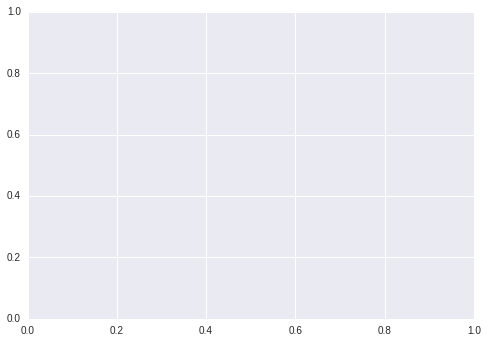

In [4]:
def make_covariance_ellipse(covariance, mean, std=2):
    import matplotlib.patches as patches
    import scipy.linalg       as linalg
    
    # the ellipse is centered at (0,0)
    # mean = np.array([0,0])
    
    # eigenvalue decomposition of the covariance matrix (w are eigenvalues and v eigenvectors),
    # keeping only the real part
    w,v = linalg.eigh(covariance)
    # normalize the eigenvector corresponding to the largest eigenvalue
    u = v[0]/linalg.norm(v[0])
    # angle in degrees
    angle = 180.0/np.pi*np.arctan(u[1]/u[0])
    # fill Gaussian ellipse at 2 standard deviation
    ellipse = patches.Ellipse(mean, std*w[0]**0.5, std*w[1]**0.5, 180+angle, color='orange', alpha=0.3)
    
    return ellipse

# represent the Euclidean distance
figure,axis = plt.subplots(1,1)
plot_data(x,y,axis)
ellipse = make_covariance_ellipse(np.eye(2))
axis.add_artist(ellipse)
axis.set_title('Euclidean distance')
plt.show()

In [ ]:
# number of target neighbours per example
k = 2

lmnn = LMNN(k, min_iter=50, max_iter=1000, convergence_tol=1e-9)
lmnn.fit(x, y)

In [ ]:
# get the linear transform from LMNN
L = lmnn.transformer()
# square the linear transform to obtain the Mahalanobis distance matrix
M = np.matrix(lmnn.metric())

print M.I

# represent the distance given by LMNN
figure,axis = plt.subplots(1,1)
plot_data(x,y,axis)
ellipse = make_covariance_ellipse(M.I)
axis.add_artist(ellipse)
axis.set_title('LMNN distance')
plt.show()

## Shogun version

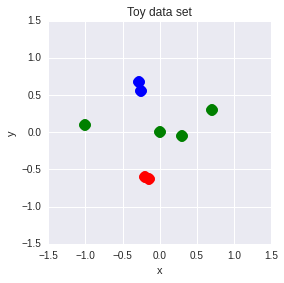

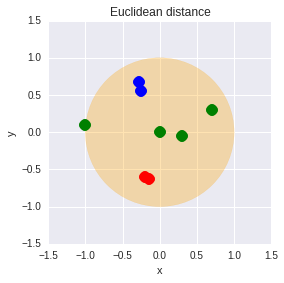

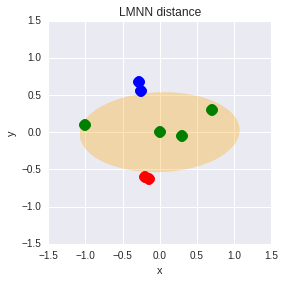

[[ 0.93495512 -0.03239161]
 [-0.03207083  1.8724276 ]]


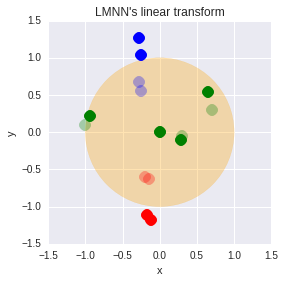

In [8]:
import numpy

x = numpy.array([[0,0],[-1,0.1],[0.3,-0.05],[0.7,0.3],[-0.2,-0.6],[-0.15,-0.63],[-0.25,0.55],[-0.28,0.67]])
y = numpy.array([0,0,0,0,1,1,2,2])

import matplotlib.pyplot as pyplot

%matplotlib inline

def plot_data(features,labels,axis,alpha=1.0):
    # separate features according to their class
    X0,X1,X2 = features[labels==0], features[labels==1], features[labels==2]
    
    # class 0 data
    axis.plot(X0[:,0], X0[:,1], 'o', color='green', markersize=12, alpha=alpha)
    # class 1 data
    axis.plot(X1[:,0], X1[:,1], 'o', color='red', markersize=12, alpha=alpha)
    # class 2 data
    axis.plot(X2[:,0], X2[:,1], 'o', color='blue', markersize=12, alpha=alpha)
    
    # set axes limits
    axis.set_xlim(-1.5,1.5)
    axis.set_ylim(-1.5,1.5)
    axis.set_aspect('equal')
    
    axis.set_xlabel('x')
    axis.set_ylabel('y')

figure,axis = pyplot.subplots(1,1)
plot_data(x,y,axis)
axis.set_title('Toy data set')
pyplot.show()

def make_covariance_ellipse(covariance):
    import matplotlib.patches as patches
    import scipy.linalg       as linalg
    
    # the ellipse is centered at (0,0)
    mean = numpy.array([0,0])
    
    # eigenvalue decomposition of the covariance matrix (w are eigenvalues and v eigenvectors),
    # keeping only the real part
    w,v = linalg.eigh(covariance)
    # normalize the eigenvector corresponding to the largest eigenvalue
    u = v[0]/linalg.norm(v[0])
    # angle in degrees
    angle = 180.0/numpy.pi*numpy.arctan(u[1]/u[0])
    # fill Gaussian ellipse at 2 standard deviation
    ellipse = patches.Ellipse(mean, 2*w[0]**0.5, 2*w[1]**0.5, 180+angle, color='orange', alpha=0.3)
    
    return ellipse

# represent the Euclidean distance
figure,axis = pyplot.subplots(1,1)
plot_data(x,y,axis)
ellipse = make_covariance_ellipse(numpy.eye(2))
axis.add_artist(ellipse)
axis.set_title('Euclidean distance')
pyplot.show()

from modshogun import RealFeatures, MulticlassLabels

features = RealFeatures(x.T)
labels   = MulticlassLabels(y.astype(numpy.float64))

from modshogun import LMNN

# number of target neighbours per example
k = 1

lmnn = LMNN(features,labels,k)
# set an initial transform as a start point of the optimization
init_transform = numpy.eye(2)
lmnn.set_maxiter(2000)
lmnn.train(init_transform)

# get the linear transform from LMNN
L = lmnn.get_linear_transform()
# square the linear transform to obtain the Mahalanobis distance matrix
M = numpy.matrix(numpy.dot(L.T,L))

# represent the distance given by LMNN
figure,axis = pyplot.subplots(1,1)
plot_data(x,y,axis)
ellipse = make_covariance_ellipse(M.I)
axis.add_artist(ellipse)
axis.set_title('LMNN distance')
pyplot.show()

# project original data using L
lx = numpy.dot(L,x.T)

print L

# represent the data in the projected space
figure,axis = pyplot.subplots(1,1)
plot_data(lx.T,y,axis)
plot_data(x,y,axis,0.3)
ellipse = make_covariance_ellipse(numpy.eye(2))
axis.add_artist(ellipse)
axis.set_title('LMNN\'s linear transform')
pyplot.show()